# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss_with_reg, loss)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!https://github.com/olegpolivin/dlcourse_ai.git

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.216398, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.153856, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.099106, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285874, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.168890, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.063678, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.365672, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.103934, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.222549, Train accuracy: 0.210333, val accuracy: 0.218000
Loss: 2.059842, Train accuracy: 0.233111, val accuracy: 0.237000
Loss: 2.115231, Train accuracy: 0.260667, val accuracy: 0.257000
Loss: 2.090787, Train accuracy: 0.272111, val accuracy: 0.275000
Loss: 2.098957, Train accuracy: 0.288222, val accuracy: 0.292000
Loss: 1.974340, Train accuracy: 0.306889, val accuracy: 0.310000
Loss: 2.011588, Train accuracy: 0.333000, val accuracy: 0.336000
Loss: 1.819071, Train acc

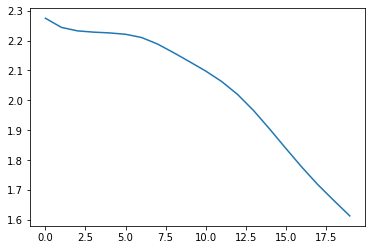

In [10]:
plt.plot(loss_history)

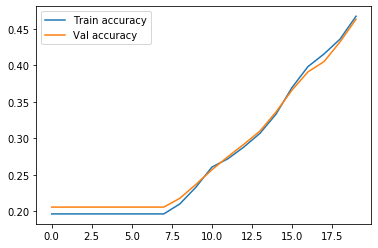

In [11]:
plt.plot(train_history, label='Train accuracy')
plt.plot(val_history, label='Val accuracy')
plt.legend()

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.245382, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.372504, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.207905, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259103, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.180887, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.191641, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.081185, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321212, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246704, Train accuracy: 0.202778, val accuracy: 0.212000
Loss: 2.189141, Train accuracy: 0.231111, val accuracy: 0.238000
Loss: 2.074268, Train accuracy: 0.243778, val accuracy: 0.247000
Loss: 2.086563, Train accuracy: 0.271111, val accuracy: 0.272000
Loss: 2.373452, Train accuracy: 0.278222, val accuracy: 0.275000
Loss: 1.735182, Train accuracy: 0.284444, val accuracy: 0.289000
Loss: 2.276342, Train accuracy: 0.307667, val accuracy: 0.311000
Loss: 1.906094, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.144626, Train accuracy: 0.197333, val accuracy: 0.206000
Loss: 1.622121, Train accuracy: 0.355222, val accuracy: 0.358000
Loss: 1.265590, Train accuracy: 0.554000, val accuracy: 0.547000
Loss: 1.426333, Train accuracy: 0.609222, val accuracy: 0.590000
Loss: 1.316831, Train accuracy: 0.673889, val accuracy: 0.653000
Loss: 1.585551, Train accuracy: 0.671222, val accuracy: 0.662000
Loss: 0.881241, Train accuracy: 0.727556, val accuracy: 0.678000
Loss: 0.963371, Train accuracy: 0.728889, val accuracy: 0.666000
Loss: 0.960361, Train accuracy: 0.750222, val accuracy: 0.703000
Loss: 1.111276, Train accuracy: 0.773000, val accuracy: 0.697000
Loss: 0.505593, Train accuracy: 0.783444, val accuracy: 0.709000
Loss: 0.590929, Train accuracy: 0.811667, val accuracy: 0.725000
Loss: 0.583194, Train accuracy: 0.829333, val accuracy: 0.728000
Loss: 0.286914, Train accuracy: 0.804000, val accuracy: 0.719000
Loss: 1.040563, Train accuracy: 0.835000, val accuracy: 0.731000
Loss: 0.458959, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.351801, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319693, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295926, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.345443, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310013, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.326544, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.255641, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.199259, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.164561, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.025661, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.883798, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.263931, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.662918, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.245522, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.943906, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.663953, Train acc

Loss: 1.212850, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.196541, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 1.280346, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.403204, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.229377, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.400568, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.391042, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.102808, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.445285, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.406323, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.219193, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.449330, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.304464, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.494726, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.327706, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.361608, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [15]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=0.33, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.303493, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.272501, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.112325, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.223673, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.279593, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.022219, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.724254, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.406655, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.777473, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.856513, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 1.829882, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 0.995744, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.922113, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.554490, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.440609, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 0.336933, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

The idea will be the following: first, we choose among large range of parameters, and then I will adjust further.

In [16]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-2]
reg_strength = [1e-5, 1e-4]
learning_rate_decay = [0.9, 0.99]
hidden_layer_size = [300]
num_epochs = 200
batch_size = 64
best_classifier = None
best_val_accuracy = -1
coef_to_val_accuracy = {}

loss_history = []
train_history = []
val_history = []


# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
dataset = Dataset(train_X, train_y, val_X, val_y)
for lr in learning_rates:
    for reg in reg_strength:
        for lrd in learning_rate_decay:
            for hidden_layer_s in hidden_layer_size:
                model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_s, reg = reg)
                trainer = Trainer(model,
                                  dataset,
                                  MomentumSGD(),
                                  num_epochs = num_epochs,
                                  batch_size = batch_size,
                                  learning_rate=lr,
                                  learning_rate_decay=lrd)
                print(f'Fitting: learning rate = {lr}, regularization strength = {reg}, learning rate decay = {lrd}, hidden_layer_size = {hidden_layer_s}' )

                loss_history, train_history, val_history = trainer.fit()
                coef_to_val_accuracy[(lr, reg, hidden_layer_s)] = val_history[-1]
                print(f'Resulting accuracy is {val_history[-1]}\n')
                if val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = val_history[-1]
print('best validation accuracy achieved: %f' % best_val_accuracy)

Fitting: learning rate = 0.01, regularization strength = 1e-05, learning rate decay = 0.9, hidden_layer_size = 300
Loss: 2.326941, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.109972, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.173154, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253461, Train accuracy: 0.255667, val accuracy: 0.250000
Loss: 1.991817, Train accuracy: 0.282889, val accuracy: 0.280000
Loss: 1.873679, Train accuracy: 0.347556, val accuracy: 0.343000
Loss: 1.681974, Train accuracy: 0.411556, val accuracy: 0.399000
Loss: 1.506193, Train accuracy: 0.447444, val accuracy: 0.437000
Loss: 1.357056, Train accuracy: 0.482333, val accuracy: 0.485000
Loss: 1.700768, Train accuracy: 0.518000, val accuracy: 0.517000
Loss: 1.372289, Train accuracy: 0.535889, val accuracy: 0.534000
Loss: 1.423331, Train accuracy: 0.568778, val accuracy: 0.566000
Loss: 1.329288, Train accuracy: 0.582000, val accuracy: 0.571000
Loss: 1.139940, Train accuracy: 0.602333

Loss: 1.037857, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 0.979279, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.207899, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.086362, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.341553, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.133942, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 0.717548, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.286119, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.021807, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.137245, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.178175, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 0.972548, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.041782, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 0.999855, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.245629, Train accuracy: 0.685222, val accuracy: 0.661000
Loss: 1.282257, Train acc

Loss: 0.210513, Train accuracy: 0.926000, val accuracy: 0.772000
Loss: 0.313489, Train accuracy: 0.922444, val accuracy: 0.773000
Loss: 0.330036, Train accuracy: 0.916667, val accuracy: 0.759000
Loss: 0.157636, Train accuracy: 0.930556, val accuracy: 0.776000
Loss: 0.396174, Train accuracy: 0.937889, val accuracy: 0.777000
Loss: 0.397930, Train accuracy: 0.926778, val accuracy: 0.765000
Loss: 0.271690, Train accuracy: 0.939667, val accuracy: 0.775000
Loss: 0.279854, Train accuracy: 0.942222, val accuracy: 0.777000
Loss: 0.350314, Train accuracy: 0.938222, val accuracy: 0.770000
Loss: 0.206109, Train accuracy: 0.944889, val accuracy: 0.778000
Loss: 0.324419, Train accuracy: 0.949889, val accuracy: 0.768000
Loss: 0.249505, Train accuracy: 0.947000, val accuracy: 0.772000
Loss: 0.158831, Train accuracy: 0.940667, val accuracy: 0.773000
Loss: 0.243334, Train accuracy: 0.949778, val accuracy: 0.768000
Loss: 0.259721, Train accuracy: 0.955889, val accuracy: 0.768000
Loss: 0.323820, Train acc

Loss: 0.099782, Train accuracy: 0.997111, val accuracy: 0.777000
Loss: 0.054831, Train accuracy: 0.997111, val accuracy: 0.778000
Loss: 0.111454, Train accuracy: 0.996889, val accuracy: 0.779000
Loss: 0.054191, Train accuracy: 0.996667, val accuracy: 0.779000
Loss: 0.103092, Train accuracy: 0.997333, val accuracy: 0.778000
Loss: 0.104503, Train accuracy: 0.996889, val accuracy: 0.776000
Loss: 0.096330, Train accuracy: 0.997222, val accuracy: 0.781000
Loss: 0.073081, Train accuracy: 0.997444, val accuracy: 0.779000
Loss: 0.094699, Train accuracy: 0.997111, val accuracy: 0.780000
Loss: 0.041691, Train accuracy: 0.997444, val accuracy: 0.781000
Loss: 0.078252, Train accuracy: 0.996889, val accuracy: 0.776000
Loss: 0.056182, Train accuracy: 0.997222, val accuracy: 0.782000
Loss: 0.095252, Train accuracy: 0.997444, val accuracy: 0.784000
Loss: 0.071091, Train accuracy: 0.997222, val accuracy: 0.780000
Loss: 0.074336, Train accuracy: 0.997667, val accuracy: 0.779000
Loss: 0.038365, Train acc

Loss: 1.394997, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.237562, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.039319, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 0.980268, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.146793, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 0.974715, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.177421, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.244294, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 0.926464, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 0.777157, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 0.887923, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.076559, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 0.793681, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.249428, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.180838, Train accuracy: 0.686000, val accuracy: 0.660000
Loss: 1.110192, Train acc

Loss: 0.749836, Train accuracy: 0.816667, val accuracy: 0.738000
Loss: 0.488477, Train accuracy: 0.807556, val accuracy: 0.742000
Loss: 0.835011, Train accuracy: 0.825556, val accuracy: 0.743000
Loss: 0.444186, Train accuracy: 0.834222, val accuracy: 0.745000
Loss: 0.547824, Train accuracy: 0.828000, val accuracy: 0.732000
Loss: 0.786420, Train accuracy: 0.832778, val accuracy: 0.742000
Loss: 0.405384, Train accuracy: 0.839889, val accuracy: 0.748000
Loss: 0.831623, Train accuracy: 0.859333, val accuracy: 0.752000
Loss: 0.468180, Train accuracy: 0.865556, val accuracy: 0.752000
Loss: 0.930553, Train accuracy: 0.857000, val accuracy: 0.747000
Loss: 0.555453, Train accuracy: 0.864333, val accuracy: 0.744000
Loss: 0.514601, Train accuracy: 0.864778, val accuracy: 0.747000
Loss: 0.732195, Train accuracy: 0.868444, val accuracy: 0.743000
Loss: 0.530268, Train accuracy: 0.876778, val accuracy: 0.752000
Loss: 0.749479, Train accuracy: 0.875556, val accuracy: 0.738000
Loss: 0.540171, Train acc

Loss: 0.177569, Train accuracy: 0.993889, val accuracy: 0.790000
Loss: 0.164513, Train accuracy: 0.993333, val accuracy: 0.783000
Loss: 0.159515, Train accuracy: 0.993556, val accuracy: 0.781000
Loss: 0.123178, Train accuracy: 0.993556, val accuracy: 0.782000
Loss: 0.212560, Train accuracy: 0.994111, val accuracy: 0.785000
Loss: 0.210273, Train accuracy: 0.993556, val accuracy: 0.787000
Loss: 0.213018, Train accuracy: 0.994111, val accuracy: 0.787000
Loss: 0.218715, Train accuracy: 0.994000, val accuracy: 0.784000
Loss: 0.195259, Train accuracy: 0.994556, val accuracy: 0.789000
Loss: 0.204299, Train accuracy: 0.993889, val accuracy: 0.788000
Loss: 0.115430, Train accuracy: 0.994444, val accuracy: 0.784000
Loss: 0.256536, Train accuracy: 0.994111, val accuracy: 0.787000
Loss: 0.165595, Train accuracy: 0.994111, val accuracy: 0.784000
Loss: 0.142740, Train accuracy: 0.994111, val accuracy: 0.785000
Loss: 0.147516, Train accuracy: 0.994333, val accuracy: 0.785000
Loss: 0.179122, Train acc

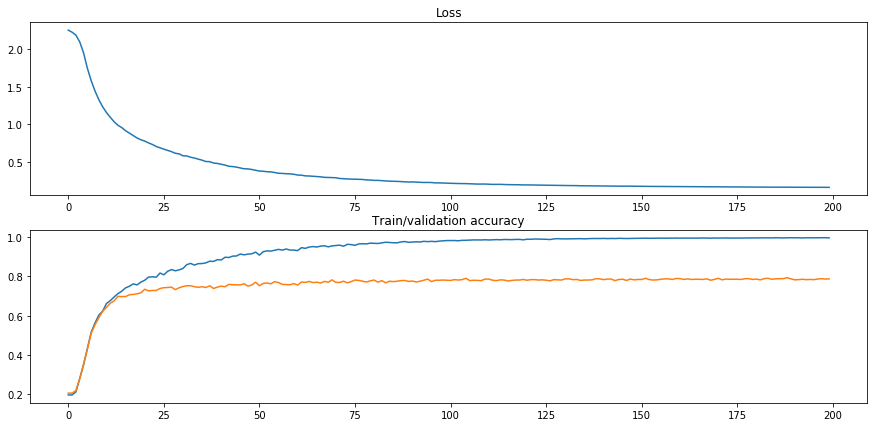

In [17]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [18]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.765000
